# A quick guide to browsing DANDI datasets

The purpose of this notebook is to give you a guideline as to how to access the metadata of all DANDI data sets available and search for specific datasets using quick parameter specifications. Much of the code is directly taken from the [DANDI docs](https://docs.dandiarchive.org/) which provide a much more in-depth exploration.

##### What we do here amounts to the following:
1) [Import all DANDI sets that are in NWB format](#datasets-on-dandi)
2) [Sort the DANDI sets by species and visualize](#species)
3) [Sort by recording method and visualize](#recordings)
4) [Access one example data set of interest based on species and recording specifications.](#specific)
5) [Load the example data set](#load)

# Datasets on DANDI

In [ ]:
import json
from dandi.dandiapi import DandiAPIClient
from tqdm.notebook import tqdm
import numpy as np
from matplotlib.pyplot import *
import operator
plt.style.use("styleSettings.mplstyle")


In [185]:
client = DandiAPIClient()
dandisets = list(client.get_dandisets())

In [186]:
nwb_dandisets = []

for dandiset in tqdm(dandisets):
    raw_metadata = dandiset.get_raw_metadata()

    if any(
        "NWB" in data_standard["name"]
        for data_standard in raw_metadata["assetsSummary"].get("dataStandard", [])
    ):
        nwb_dandisets.append(dandiset)
print(f"There are currently {len(nwb_dandisets)} NWB datasets on DANDI!")

  0%|          | 0/664 [00:00<?, ?it/s]

There are currently 391 NWB datasets on DANDI!


## Overview of datasets per species <a id="species"></a>

Let's get an overview of how many data sets are uploaded for a specific species.

In [224]:
chosen_species = ['mouse', 'rat', 'human', 'monkey', 'fish', 'elegans', 'fly', 'rabbit', 'ant'] # define which species we're interested in
dandiset_species = {s:[] for s in chosen_species}
    
for dandiset in tqdm(nwb_dandisets):
    raw_metadata = dandiset.get_raw_metadata()
    # try:
    #     print(raw_metadata["assetsSummary"]['species'][0]['name']) # check species names
    # except:
    #     continue
    for specie in chosen_species:
        if any(
            specie in species["name"].lower()
            for species in raw_metadata["assetsSummary"].get("species", [])
        ):
            dandiset_species[specie].append(raw_metadata['identifier'])

# combine to zebrafish names
dandiset_species['fish'] = np.append(dandiset_species['fish'], dandiset_species['elegans'])
dandiset_species.pop('elegans')
chosen_species.remove('elegans')

print(f"Chosen species account for {np.sum([len(dandiset_species[s]) for s in chosen_species])} NWB datasets on DANDI.")

  0%|          | 0/391 [00:00<?, ?it/s]

Chosen species account for 366 NWB datasets on DANDI.


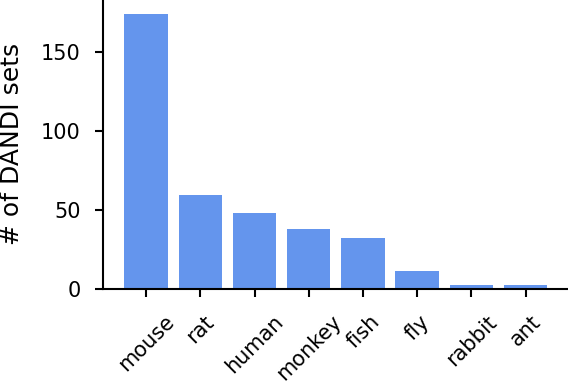

In [225]:
# get number of DANDISETS per species
num_species = {s: len(dandiset_species[s]) for s in chosen_species}
num_species = dict(sorted(num_species.items(), key=lambda item: item[1], reverse=True))
6
figure()
for s_id, s in enumerate(num_species.keys()):
    bar(s_id, num_species[s], color='cornflowerblue');
xticks(np.arange(len(num_species)), num_species.keys(), rotation=45);
ylabel('# of DANDI sets')
savefig('./DatasetsBySpecies')

## Which type of recordings are most often uploaded? <a id="recordings"></a>

In [189]:
chosen_recordings = ['microscopy', 'electrophysiolog', 'two-photon', 'one-photon', 'current clamp', 'voltage clamp']
dandiset_recording = {r:[] for r in chosen_recordings}
    
for dandiset in tqdm(nwb_dandisets):
    raw_metadata = dandiset.get_raw_metadata()
    # try: #explore the chosen names for variable techniques
    #     print(' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']])) # check species names
    # except:
    #     continue
    for record in chosen_recordings: # determine which of the specified techniques is used
        if record in ' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']]):
            dandiset_recording[record].append(raw_metadata['identifier'])

print(f"Chosen recordings account for {np.sum([len(dandiset_recording[r]) for r in chosen_recordings])} NWB datasets on DANDI.")

  0%|          | 0/391 [00:00<?, ?it/s]

Chosen recordings account for 268 NWB datasets on DANDI.


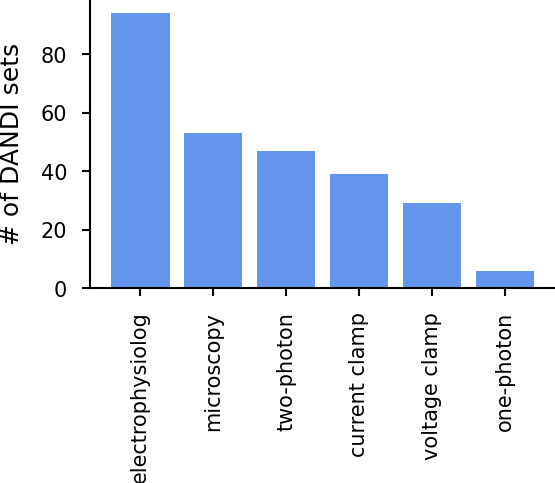

In [190]:
# get number of DANDISETS per species, sort by occurence
num_recording = {s: len(dandiset_recording[s]) for s in chosen_recordings}
num_recording = dict(sorted(num_recording.items(), key=lambda item: item[1], reverse=True))

figure()
for r_id, r in enumerate(num_recording.keys()):
    bar(r_id, num_recording[r], color='cornflowerblue');
xticks(np.arange(len(num_recording)), num_recording.keys(), rotation=90);
ylabel('# of DANDI sets')
savefig('./DatasetsByImaging')

# Let's look for a specific dataset! <a id="specific"></a>

We want to get more specific and query a data set based on both species and recording type.

Let's imagine we're interested in all **ant** eyperiments using **two-photon imaging**...

In [239]:
# example: mouse + two-photon
variables = {'species': 'ant', 'recording': 'two-photon'}

specifc_recording = []
for dandiset in tqdm(nwb_dandisets): # search all dandisets
    raw_metadata = dandiset.get_raw_metadata()

    if any(variables['species'] in species["name"].lower() for species in raw_metadata["assetsSummary"].get("species", [])) &\
                (variables['recording'] in ' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']])): # specify variables of interest
            specifc_recording.append(raw_metadata['identifier'])

print(f'There are {len(specifc_recording)} experiments matching: {variables} .')

  0%|          | 0/391 [00:00<?, ?it/s]

There are 2 experiments matching: {'species': 'ant', 'recording': 'two-photon'} .


Voilá, we only have **two** potential data sets left! We want to first access more metadata from the first data set that shows up to get details of the experiments, potentially linked papers, number of subjects, etc.

In [240]:
# get example session name
example_set = specifc_recording[0].replace('DANDI:','')
# get the associated dataset
dandiset = client.get_dandiset(example_set)
# print the belonging metadata
print(f"Example DANDI set {example_set} metadata:\n")
dandiset.get_raw_metadata()

Example DANDI set 000467 metadata:



{'id': 'DANDI:000467/draft',
 'url': 'https://dandiarchive.org/dandiset/000467/draft',
 'name': 'Sparse and stereotyped encoding implicates a core glomerulus for ant alarm behavior',
 'about': [],
 'access': [{'status': 'dandi:OpenAccess', 'schemaKey': 'AccessRequirements'}],
 'license': ['spdx:CC-BY-4.0'],
 'version': 'draft',
 '@context': 'https://raw.githubusercontent.com/dandi/schema/master/releases/0.6.4/context.json',
 'citation': 'Sparse and stereotyped encoding implicates a core glomerulus for ant alarm behavior (2024). (Version draft) [Data set]. DANDI archive. https://dandiarchive.org/dandiset/000467/draft',
 'keywords': ['antennal lobe; calcium imaging; chemosensation; clonal raider ant; communication; GCaMP; odor coding; olfaction; Ooceraea biroi; pheromone'],
 'protocol': [],
 'schemaKey': 'Dandiset',
 'identifier': 'DANDI:000467',
 'repository': 'https://dandiarchive.org',
 'contributor': [{'name': 'National Institutes of Health (NIH)',
   'roleName': ['dcite:Funder'],
  

If this approach seems too messy, you can always explore the datasets more visually on [DANDI](https://dandiarchive.org/dandiset/000467/draft) using the URL or DANDI ID of the data set of interest.\
You can also explore the dataset directly in the DANDIHUB without having to download them. Also check in the /dandi-notebooks folder to see if there is already an associated example notebook to get you started.

## Load the example DANDI set! <a id="load"></a>

In [238]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = specifc_recording[0].replace('DANDI:','')
file_path = "sub-17797/sub-17797_ses-9-scan-4_behavior+image+ophys.nwb" # file size ~67GB

# Get the location of the file on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)